In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

In [3]:
archetype_data = pd.read_csv('../../data/enriched/persona_identification/archetype_predictions_joined.csv')

character_data = pd.read_csv('../../data/MovieSummaries/alex_character_processed.csv')

character_data = character_data.rename(columns={
    'Wikipedia movie ID': "wikipedia_movie_id",
    'Freebase movie ID': "fb_movie_id",
    'Character name': "character_name",
    'Actor gender': "actor_gender",
    'Actor height (in meters)': "actor_height",
    'Actor ethnicity (Freebase ID)': "fb_actor_eth_id",
    'Actor name': "actor_name",
    'Freebase character/actor map ID': "fb_char_actor_map_id",
    'Freebase character ID': "fb_char_id",
    'Freebase actor ID': "fb_actor_id",
})

character_data = character_data.drop_duplicates(subset=["fb_movie_id", "fb_actor_id", "character_name"])

actor_data = pd.read_csv('../../data/enriched/actors/actors_freebase.csv')
actor_data = actor_data[["education", "professions_num", "date_of_birth", "nationality", "gender", "place_of_birth", "height", "weight", "religion", "id"]]

merged = pd.merge(
    archetype_data, 
    character_data, 
    how="inner", 
    left_on=["actor_fb_id", "movie_fb_id", "character_name"], 
    right_on=["fb_actor_id", "fb_movie_id", "character_name"]
)
merged = pd.merge(merged, actor_data, how="left", left_on="actor_fb_id", right_on="id").copy()

merged.loc[merged.actor_height.isna() & ~merged.height.isna(), "actor_height"] = merged[merged.actor_height.isna() & ~merged.height.isna()].height
merged.loc[merged.actor_gender.isna() & ~merged.gender.isna(), "actor_gender"] = merged[merged.actor_gender.isna() & ~merged.gender.isna()].gender

data = merged[[
    'prediction', 'character_name',
    'movie_name', 'actor_gender', 'actor_height',
    'actor_name', 'actor_date_of_birth', 'movie_release_date', 'ethn_name',
    'race', 'education', 'professions_num', 'nationality',
    'gender', 'place_of_birth', 'weight', 'religion', "fb_movie_id", "fb_actor_id"
]].copy()
# # delete some ourliers, by looking at the histogram
MIN_HEIGHT = 0.8
MAX_HEIGHT = 2.7 # Max Palmen had height 249 cm
data = data[((data.actor_height >= MIN_HEIGHT) & (data.actor_height <= MAX_HEIGHT)) | data.actor_height.isna()].copy()
data["years_in_film"] = (pd.to_datetime(data.movie_release_date) - pd.to_datetime(data.actor_date_of_birth)).dt.days / 365.25
data["actor_bmi"] = data.weight / (data.actor_height ** 2)
data.loc[~data.education.isna(), "education"] = data.loc[~data.education.isna(), "education"].astype(int)
data.loc[data.actor_gender == "Male", "actor_gender"] = "M"
data.loc[data.actor_gender == "Female", "actor_gender"] = "F"
data.rename(columns={"prediction": "archetype"}, inplace=True)
data.shape

(87210, 21)

For now we do not have any information about the archetypes so I will randomly generate them

# Question 2

Which Actor Traits Correspond to Specific Archetypes?\
Which actor traits — such as age, gender, ethnicity, and other physical attributes — are typically associated with specific archetypes? For instance, are certain traits more frequently linked to roles like heroes, villains, or mentors? Investigating these correlations can reveal patterns in casting decisions.

In [ ]:
actor_traits_numerical_columns = ["actor_height", "weight", "years_in_film", "actor_bmi"]
actor_traits_categorial_columns = ["actor_gender", "race", "education", "religion", "nationality", "place_of_birth"]

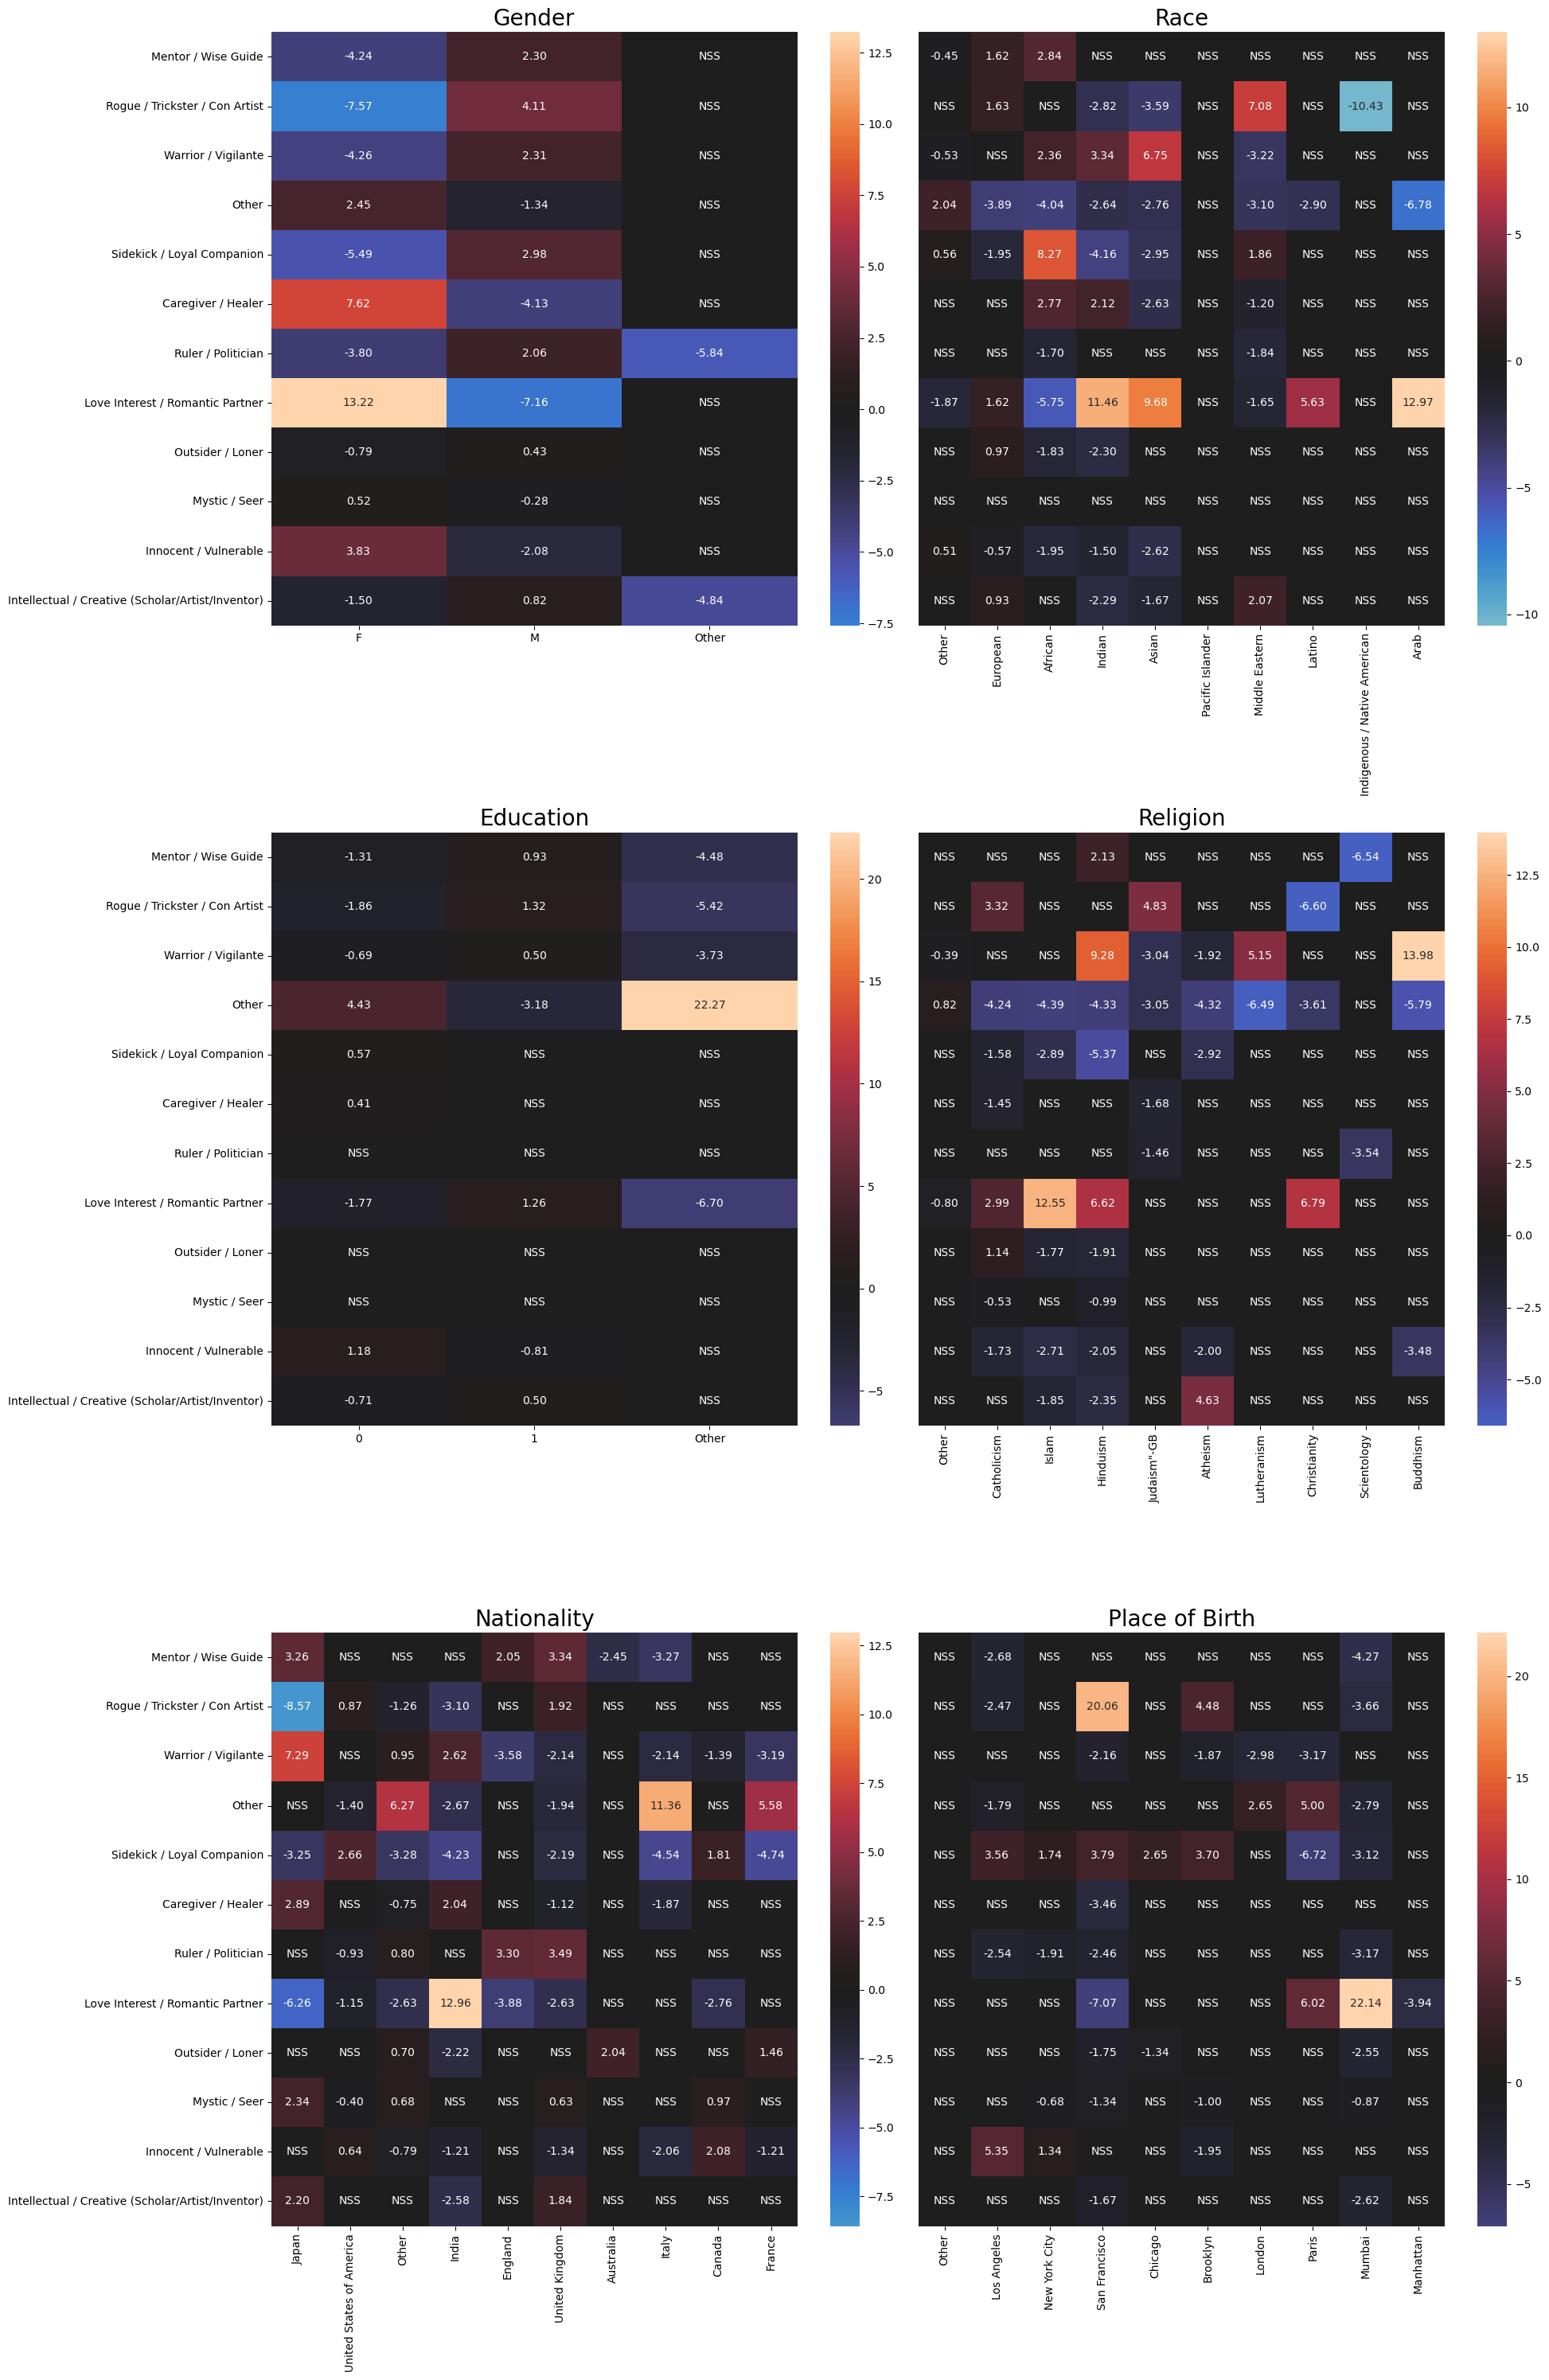

In [273]:
import os
import sys
sys.path.append(os.path.join(os.getcwd(), "../visualization"))
from plot_3d_like import histogram_3d_plotly, calculate_ticks_and_norm, plot_2d_heatmap

plt.figure(figsize=(2 * 10, 3 * 10))
for i, (s, title) in enumerate(zip(
    ["actor_gender", "race", "education", "religion", "nationality", "place_of_birth"],
    ["Gender", "Race", "Education", "Religion", "Nationality", "Place of Birth"],
)):
    plt.subplot(3, 2, i + 1)
        
    plt.title(title, fontsize=20)
    grid = plot_2d_heatmap(
        data, s, "archetype", 
        normalize="first", 
        compare_default_value="subtract",
        percentage=True,
        num_ybins=13,
        mht=True
    )
    if not i in [0, 2, 4]:
        plt.yticks([])
plt.tight_layout()

To answer this question we need to understand if $P(Archetype)$ differs from $P(Archetype|Feature)$. The heatmap represents $P(Archetype|Feature) - P(Archetype)$. The blue color is for the negative values, and the orange is for the positive ones, and `NSS` means that the difference is not significant. \

- Conditioning on `Gender` shows an interesting law --- if the probability to play a specific archetype increases for `Female` actors then it decreases for `Male` actors and vice versa. Actually, it works for every archetype in our dataset, but the most significant ones are `Love Interest/Romantic Partner` (Female +13%, Male -7%), `Caregiver/Healer` (Female +7%, Male -4%), `Rogue / Trickster / Con Artist` (Female -7% Male +4%), and `Sidekick / Local Companyon` (Female -5%, Male 3%). 


- Conditioning on `Race` shows that probability to play `Love Interest/Romantic Partner` significanlty increasese for `Indian` (+11%), `Asian`(+9%), `Latino` (+5%), and `Arab` (+13%) and decreases for `African` (-5%). Probably the number of Turkish melodrama does change the usual distribution. The probability to play `Rogue / Trickster / Con Artist` are increases if an actor is `Middle Eastern` (+7%), and decreases if the actor is `Indigenous / Native American`. 

- Conditioning on `Education` doesn't show very significant changes in probability. 

- Conditioning on `Religion` shows a high dramatic increase of the probability to play `Warrior / Vigilante` for `Buddish` and `Hinduism` (almost +10%). Usually those religions are take place in `Asia` and `India`, so we can see the connection between the cultures in movies. Another interesting thing is that there is increase in probability to play this role for races `Indian` and `Asian` actors, but in a smaller way (+3% and +6%) and for nationalities `Japan` and `Indian`

- Conditioning on `Nationality` shows a significant decrease for `Japan` and (-8%). One also can notice a very high increase to play `Love Interest/Romantic Partner` for `Indian` actors (+13%). And even more, for actors who were born in Mumbai the probability of the same event increase on 22%. 

- Another interesting observation shows that the probability to play `Rogue / Trickster / Con Artist` increases on 20% for actos who were born in `San Francisco`.



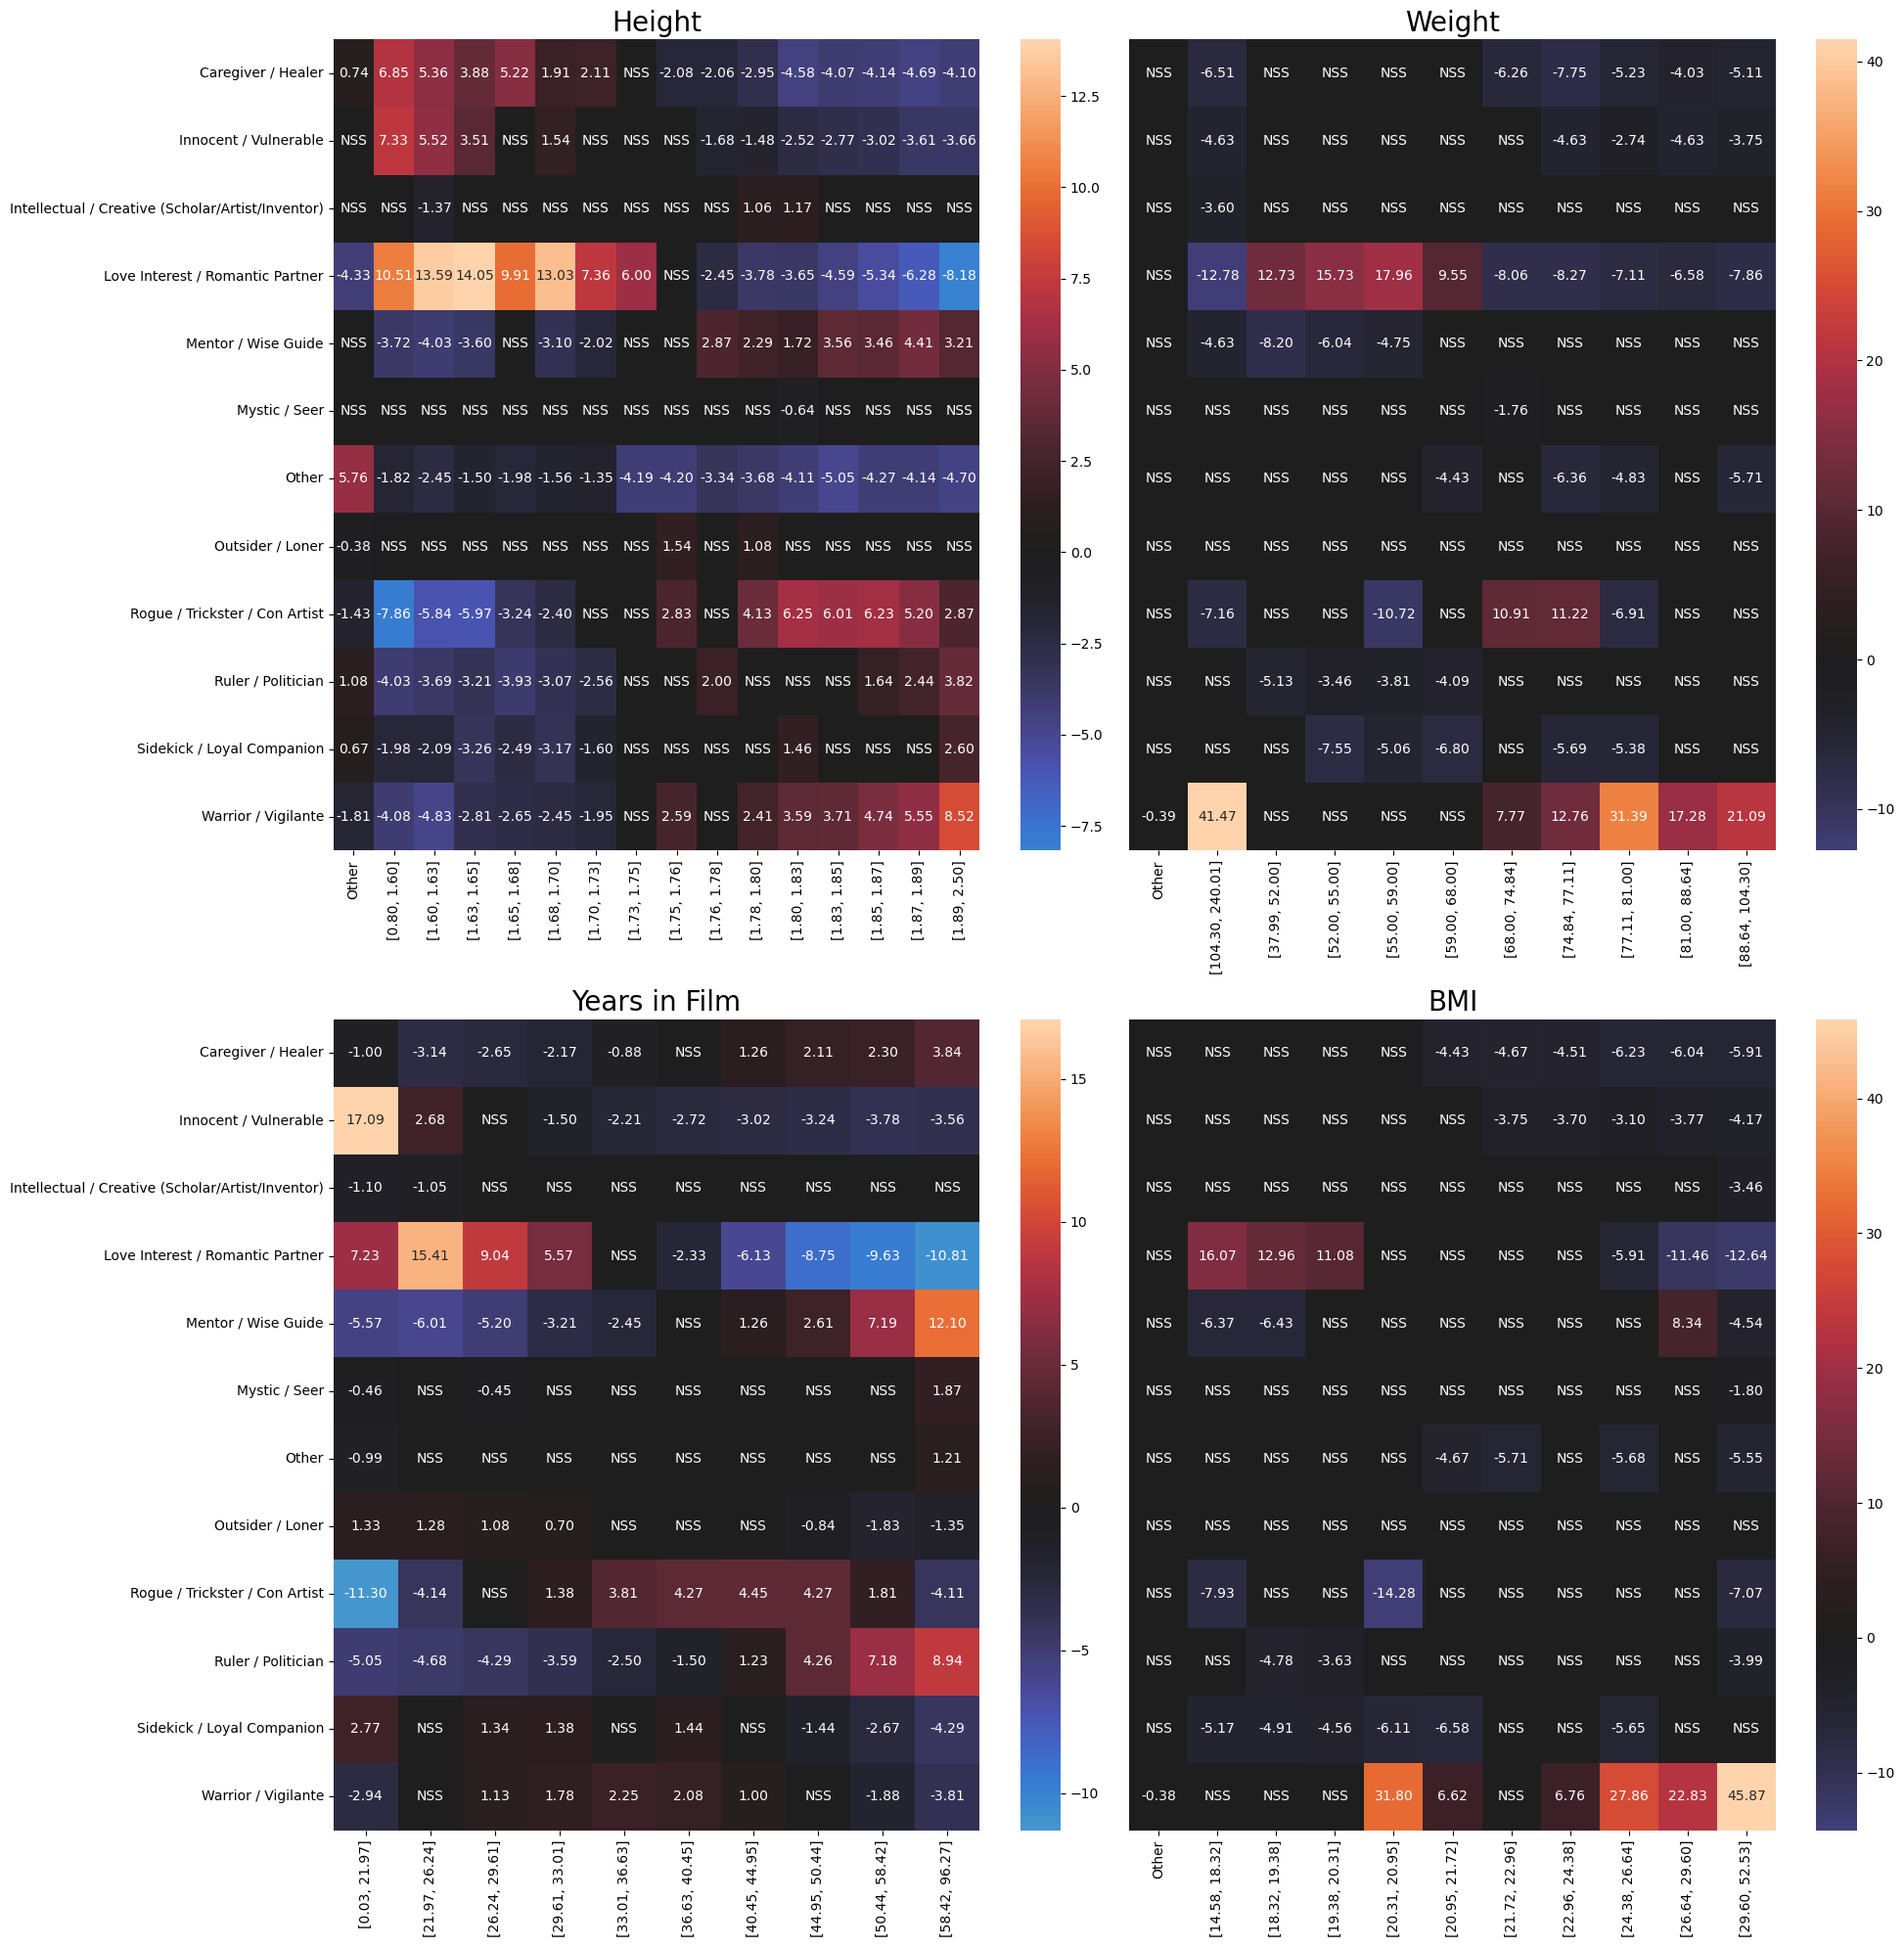

In [303]:
import os
import sys
sys.path.append(os.path.join(os.getcwd(), "../visualization"))
from plot_3d_like import histogram_3d_plotly, calculate_ticks_and_norm, plot_2d_heatmap

plt.figure(figsize=(2 * 10, 2 * 10))
for i, (s, title) in enumerate(zip(
    ["actor_height", "weight", "years_in_film", "actor_bmi"],
    ["Height", "Weight", "Years in Film", "BMI"],
)):
    plt.subplot(2, 2, i + 1)
        
    plt.title(title, fontsize=20)
    grid = plot_2d_heatmap(
        data, s, "archetype", 
        normalize="first", 
        compare_default_value="subtract",
        percentage=True,
        num_ybins=13,
        num_xbins = 15 if title == "Height" else 10,
        mht=True
    )
    if not i in [0, 2]:
        plt.yticks([])
plt.tight_layout()

In [268]:
data.archetype.unique()

array(['Mentor / Wise Guide', 'Rogue / Trickster / Con Artist',
       'Warrior / Vigilante', 'Other', 'Sidekick / Loyal Companion',
       'Caregiver / Healer', 'Ruler / Politician',
       'Love Interest / Romantic Partner', 'Outsider / Loner',
       'Mystic / Seer', 'Innocent / Vulnerable',
       'Intellectual / Creative (Scholar/Artist/Inventor)'], dtype=object)

This figure represents $P(Archetype|Feature) - P(Archetype)$ for numerical features. The bins are sampled such that the **probability** of each bin is uniform, i.e. we $\text{bin}_i$ represents $[\operatorname{quantile}(\frac{i}{n}), \operatorname{quantile}(\frac{i}{n + 1})]$. The blue color is for the negative values, and the orange is for the positive ones, and `NSS` means that the difference is not significant. \

- Conditioning on `Height` shows that the probability to play `Love Interest / Romantic Partner` (by 14% at max), `Innocent / Vulnerable` (by 7% at max), and `Caregiver / Healer` (by 7% at max) are higher for lower people. More suprisingly, the probability firstly **monotonically** increases until some height, and then start to decrease also **monotonically**. Even more surprisingly is that the height for the maximum heigh are different for `Love Interest / Romantic Partner` and `Caregiver / Healer`, but they are close (difference is < 3 cm). One can also notice that if an actor is high tall then it has more changes to play `Mentor / Wise Guide` (by 4% at 188cm) `Rogue / Trickster / Con Artist` (by 6% at 180cm) and `Warrior / Vigilante` (by 8% at 190cm). And if an actor is low then it has less chances to play a politician.

- Conditioning on `Weight` shows that for the same law for `Love Interest / Romantic Partner` --- it firstly increases and then decreases. The maximum is +18% at 57 kg. The law for `Warrior / Vigilante` is that the probability increases **monotonically** with weight and has maximum of +41% for people who weight 105+ kg. it seems that it is difficult to imagine people with big weight as `Love Interest / Romantic Partner` but more like a `Warrior`.

- Conditioning on `Age` of the actor shows that the probability to play `Innocent / Vulnerable` increases if the actor is young and monotonically decreases with age. The logical but interesting observation is that if when the actor is old then the probability to play `Mentor / Wise Guide` is higher. And this sounds super logical, because in our everyday life adults usually wiser. Okay, at least they look wiser. Additionally, the probability to play `Ruler / Politician` is higher if when the actor is older. It sounds logical too, because in our everyday life politicians are adults. The probability to play `Love Interest / Romantic Partner` has the same behaviour as for conditioning this archetype on `Height`.

- Conditioning on `BMI` shows that the chances to play `Love Interest / Romantic Partner` have the same law as for `height` -- lower is more probable. Another interesting observation is the increase probability for `Warrior / Vigilante` has two maxima. The first is at ~21 BMI and the second is at ~29+ BMI.

In [240]:
aaa = to_debug[0]
aaa

actor_gender                                    archetype_other    cnt
0             M                     Rogue / Trickster / Con Artist  13876
1             F                   Love Interest / Romantic Partner   8352
2             M                                              Other   8083
3             M                         Sidekick / Loyal Companion   7748
4             M                                Mentor / Wise Guide   6731
5             F                                              Other   5418
6             M                                Warrior / Vigilante   5071
7             F                                 Caregiver / Healer   4713
8             M                                 Ruler / Politician   4465
9             F                     Rogue / Trickster / Con Artist   3942
10            M                   Love Interest / Romantic Partner   3880
11            M  Intellectual / Creative (Scholar/Artist/Inventor)   3199
12            F                              Innocent / Vulnerable   2592
13            M                                 Caregiver / Healer   2045
14            F                                Mentor / Wise Guide   1645
15            F                         Sidekick / Loyal Companion   1606
16            M                              Innocent / Vulnerable   1438
17            F  Intellectual / Creative (Scholar/Artist/Inventor)   1023
18            F                                Warrior / Vigilante    737
19            F                                 Ruler / Politician    626
20        Other                                              Other      7
21        Other                              Innocent / Vulnerable      5
22        Other                     Rogue / Trickster / Con Artist      2
23        Other                                Mentor / Wise Guide      2
24        Other                   Love Interest / Romantic Partner      1
25        Other                                 Caregiver / Healer      1
26        Other                         Sidekick / Loyal Companion      1
27        Other                                Warrior / Vigilante      1

In [241]:
aaa[(aaa.actor_gender == 'F') & (aaa.archetype_other == 'Other')]["cnt"] / aaa[(aaa.actor_gender == 'F')]["cnt"].sum()

5    0.176747
Name: cnt, dtype: float64

In [ ]:
aaa[(aaa.actor_gender == 'F')]["cnt"].sum()

np.int64(30654)

In [249]:
theta1 = aaa[(aaa.actor_gender == 'F') & (aaa.archetype_other == 'Other')]["cnt"].values / aaa[(aaa.actor_gender == 'F')]["cnt"].sum()
num1 = aaa[(aaa.actor_gender == 'F')]["cnt"].sum()
theta2 = aaa[(aaa.archetype_other == 'Other')]["cnt"].sum() / aaa["cnt"].sum()
num2 = aaa["cnt"].sum()
print(theta1, theta2, num1, num2)

std = np.sqrt(theta1 * (1 - theta1)/num1 + theta2 * (1 - theta2)/num2)
ZZZ_score = (theta1 - theta2)/std
ZZZ_score

[0.17674692] 0.15489049420937967 30654 87210


array([8.74415259])

In [250]:
sps.norm.sf(ZZZ_score)

array([1.12347812e-18])

In [242]:
aaa[(aaa.archetype_other == 'Other')]["cnt"].sum() / aaa["cnt"].sum()

np.float64(0.15489049420937967)

In [244]:
aaa["cnt"].sum()

np.int64(87210)

In [202]:
aaa["cnt"].sum()

np.int64(87210)

In [223]:
((data.religion == 'Islam') & (data.archetype == 'Other')).sum() / (data.religion == 'Islam').sum()

np.float64(0.04838709677419355)

In [224]:
(data.archetype == 'Other').mean()

np.float64(0.09232886136910905)

<Axes: >

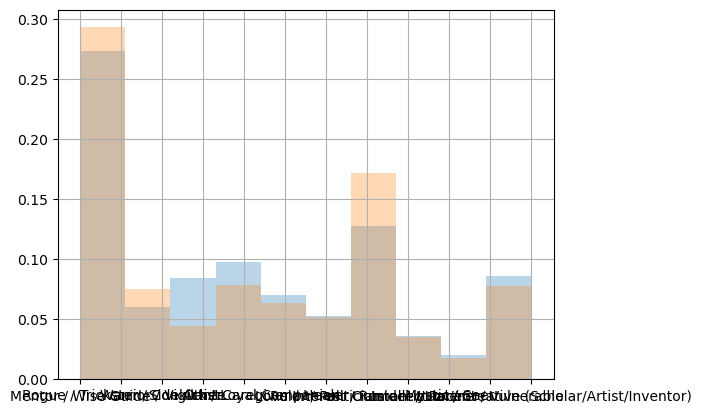

In [185]:
data.archetype.hist(density=True, alpha=0.3)
data[~data["religion"].isna()].archetype.hist(density=True, alpha=0.3)

In [6]:
histograms = []

data_part = data[["archetype", "actor_gender"]].dropna()

categories = data_part["actor_gender"].unique().tolist()
color_map = {
    gender: color for gender, color in zip(categories, plt.cm.tab20.colors[:len(categories)])
}

for category in categories:
    filtered_data = data_part[data_part["actor_gender"] == category]["archetype"]
    histograms.append(
        go.Histogram(
            x=filtered_data,
            name=f'Category {category}', 
            visible=False, 
            histnorm='probability density',
        )
    )

# the first is visible
histograms[0].visible = True

fig = go.Figure(data=histograms)

# create buttons
buttons = []
for i, category in enumerate(categories):
    button = {
        "label": category,
        "method": "update",
        "args": [
            {
                "visible": [j == i for j in range(len(categories))],
                "opacity": [1.0] * len(categories),
            },
            {"title": f"Histogram for {category}"},
        ]
    }
    buttons.append(button)

buttons.append(
     {
        "label": "all",
        "method": "update",
        "args": [
            {
                "visible": [True] * len(categories),
                "opacity": [0.3] * len(categories),
            },
            {"title": f"Histogram for {category}"},
        ],
    }  
)

# Add the buttons to the layout
fig.update_layout(
    updatemenus=[
        {
            "type": "dropdown",
            "direction": "down", 
            "showactive": True, 
            "buttons": buttons
        }
    ],
    title=f"Histogram by Category {categories[0]}",
    xaxis_title="Value Real",
    yaxis_title="Density",
    bargap=0.01,
    barmode='overlay',
)

fig.show()

For real data

# Question 3

Do Casting Patterns Exhibit Biases Based on Actor Traits?\
Do casting patterns exhibit biases based on actor traits like age, gender, or ethnicity? Are there noticeable trends in how certain demographics are cast in specific roles? Examining these patterns can shed light on potential biases within the casting industry.

<Axes: xlabel='archetype', ylabel='age_at_film'>

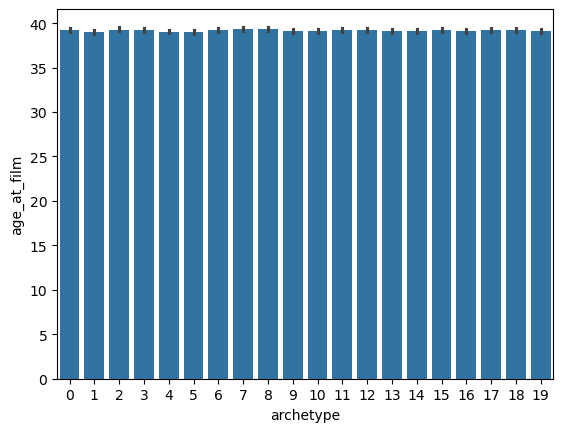

In [56]:
sns.barplot(data_actors, x="archetype", y="age_at_film")

In [ ]:
data_part = data_actors[["archetype", "age_at_film", "movie_release_date"]].dropna().copy()
data_part["year"] = data_part["movie_release_date"].dt.year
data_part = data_part[["archetype", "year", "age_at_film"]].groupby(["archetype", "year"]).mean().reset_index()

In [64]:

categories = data_part["archetype"].unique().tolist()
color_map = {
    cat: color for cat, color in zip(categories, plt.cm.tab20.colors[:len(categories)])
}

lines = []
for category in categories:
    filtered_data = data_part[data_part["archetype"] == category]
    lines.append(
        go.Scatter(
            x=filtered_data["year"],
            y=filtered_data["age_at_film"],
            name=f'{category}', 
            visible=False, 
            mode='lines',
        )
    )

# the first is visible
lines[0].visible = True

fig = go.Figure(data=lines)

# create buttons
buttons = []
for i, category in enumerate(categories):
    button = {
        "label": category,
        "method": "update",
        "args": [
            {
                "visible": [j == i for j in range(len(categories))],
                "opacity": [1.0] * len(categories),
            },
            {"title": f"Plot for {category}"},
        ]
    }
    buttons.append(button)

buttons.append(
     {
        "label": "all",
        "method": "update",
        "args": [
            {
                "visible": [True] * len(categories),
                "opacity": [0.3] * len(categories),
            },
            {"title": f"Histogram for {category}"},
        ],
    }  
)

# Add the buttons to the layout
fig.update_layout(
    updatemenus=[
        {
            "type": "dropdown",
            "direction": "down", 
            "showactive": True, 
            "buttons": buttons
        }
    ],
    title=f"Histogram by Category {categories[0]}",
    xaxis_title="Value Real",
    yaxis_title="Density",
    bargap=0.01,
    barmode='overlay',
)

fig.show()

In [ ]:
fig = px.line(data_part, x="year", y="age_at_film", color="archetype", title="Age at Film by Year")
fig.show()

In [ ]:
sns.barplot(data_actors, x="archetype", y="actor_height")

In [ ]:
sns.boxplot(data_actors, x="archetype", y="full_name_length", showfliers=False)